## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-01 11:50:58


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

## NB functions

In [6]:
def plot_csum_csum_mau(csum, csum_mau,
                            t_min      =    0,
                            t_max      = 1200,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6)):
    """Plot signal versus time in mus (tmin, tmax in mus). """
    plt.figure(figsize=figsize)
    tstep = 25 # in ns
    PMTWL = csum.shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([t_min, t_max])
    ax1.set_ylim([signal_min, signal_max])
    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "signal (pes/adc)")
    plt.plot(signal_t, csum, 'b')
    plt.plot(signal_t, csum_mau, 'r')

In [7]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times/units.mus, s12.pmts.waveform(-1))

In [8]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [9]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


## Data base

In [10]:
run_number = 5091
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [11]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [12]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,27.346,0.77,11.551
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,28.257,0.00,12.848
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,29.983,0.81,12.072
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,30.131,0.00,12.006
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,36.064,0.75,13.448
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,26.945,0.75,9.687
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,31.032,0.00,11.675
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,40.055,0.00,15.462
8,8,17,PMT8,1,63.2737,-173.8430,0.000528,5.030400e-07,28.566,0.00,11.466
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,0.000,0.00,0.000


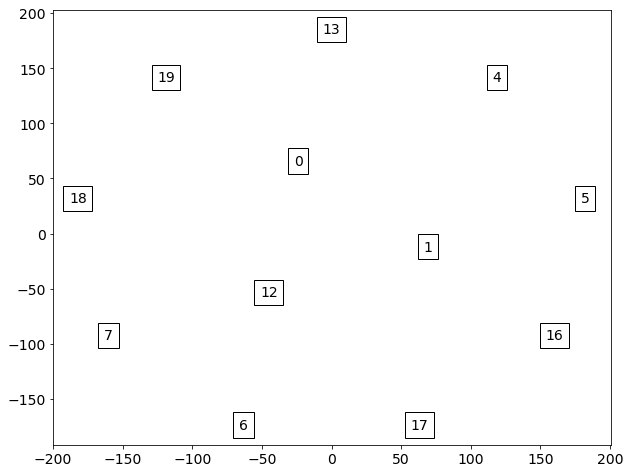

In [13]:
mpl.draw_pmt_map(run_number)

In [14]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [15]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,   0.   ,  26.082,  27.499])

In [16]:
adc_to_pes[9] = 25

In [17]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,  25.   ,  26.082,  27.499])

## Input file

In [26]:
filename = '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5091_0010_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [19]:
pmtrwf = h5rwf.root.RD.pmtrwf

In [20]:
NEVT, NPMT, PMTWL = pmtrwf.shape

In [21]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
      """.format(NEVT, NPMT, PMTWL))


        Number of events in file = 162
        Number of PMTs = 12
        PMTWL = 52000
      


## S1 and S2 parameters

In [22]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 640 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [23]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

## Event selection 

In [40]:
event=2

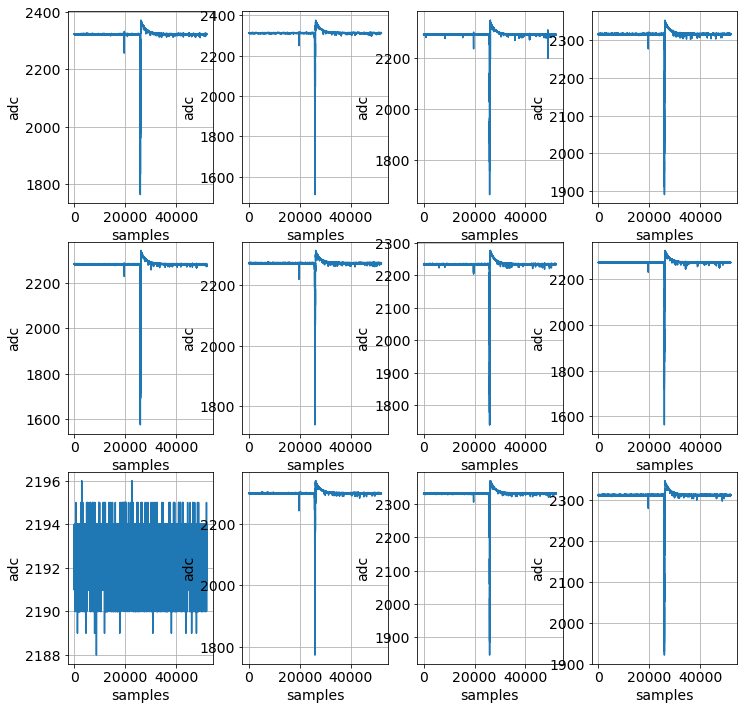

In [34]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

- Zoom to show the effect of the HPF in the RWF

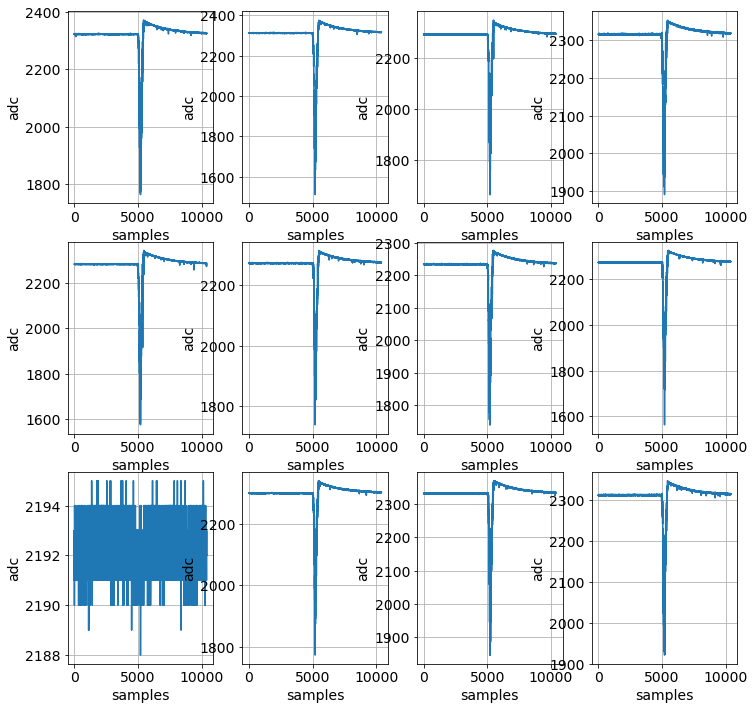

In [35]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=True, window_size=5200, figsize=(12,12))

- Deconvolution seems quite accurate

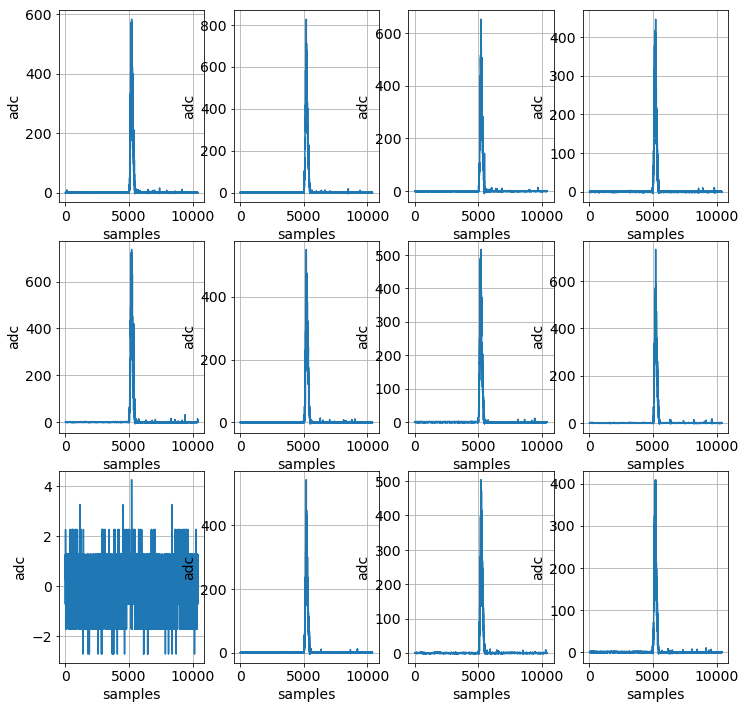

In [36]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=5200, figsize=(12,12))

- Calibrated signal in all PMTs

In [37]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

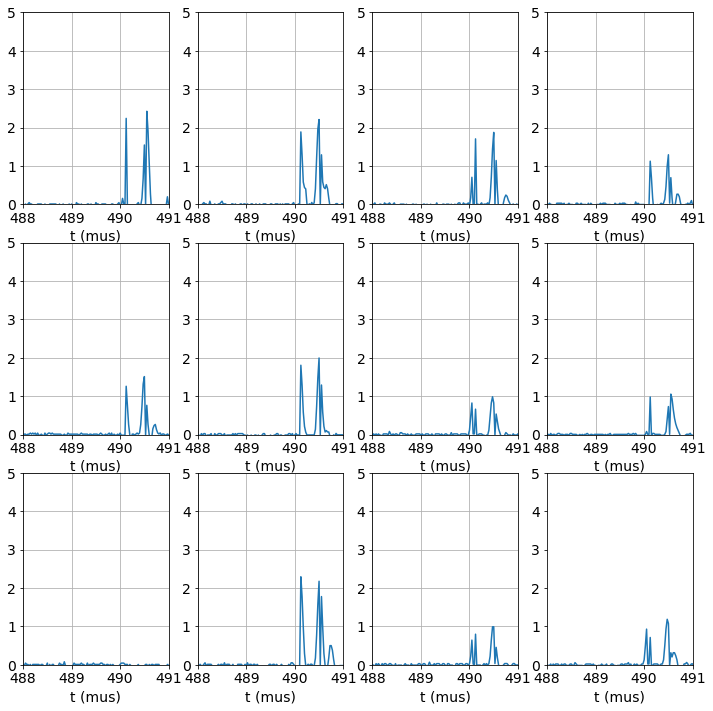

In [44]:
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    488,
                                t_max      = 491,
                                signal_min =    0,
                                signal_max =  5,
                                 figsize=(12,12))

- Calibrated sum

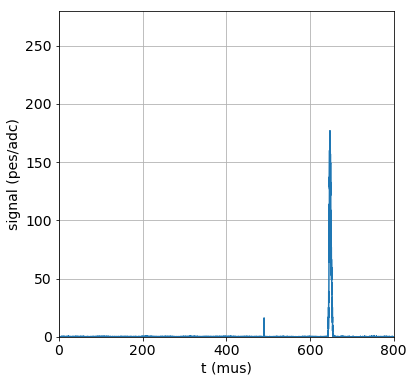

In [39]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 800,
                            signal_min =    0,
                            signal_max =  280,
                            figsize=(6,6))

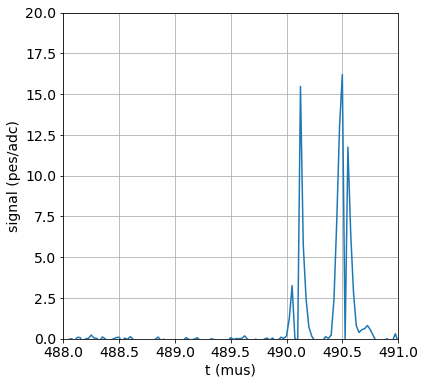

In [42]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =488,
                            t_max      = 491,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

- Multiple S1 likes, but the "true" S1 is very clear

## Event 

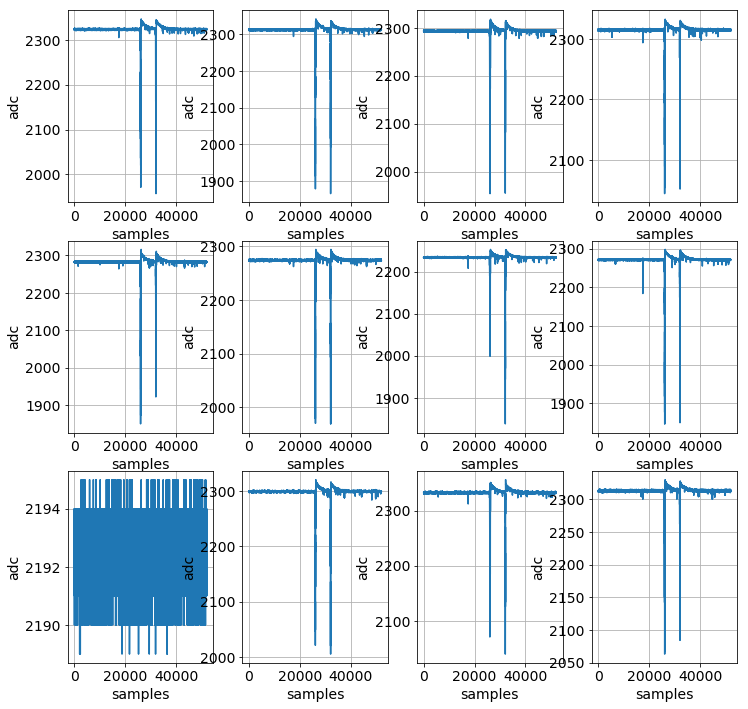

In [51]:
event=7
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

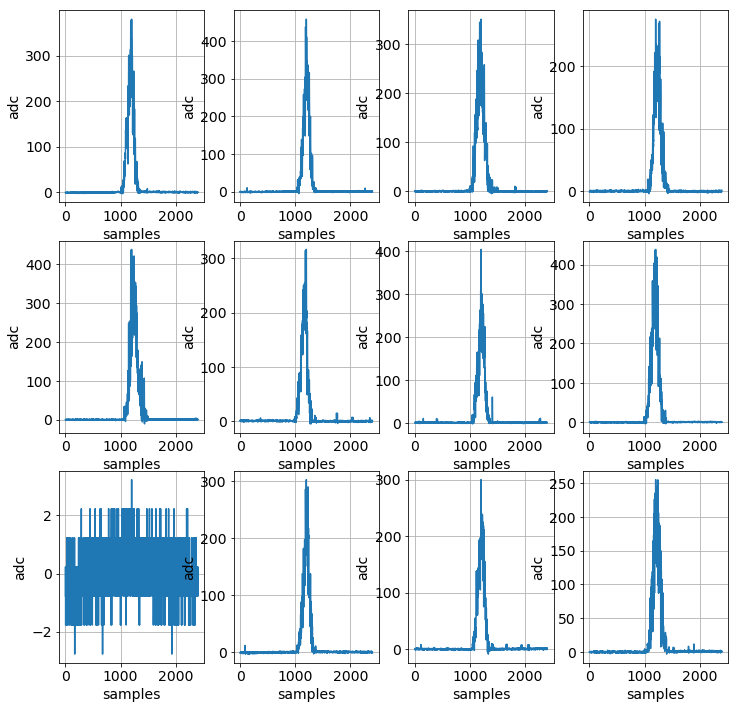

In [52]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

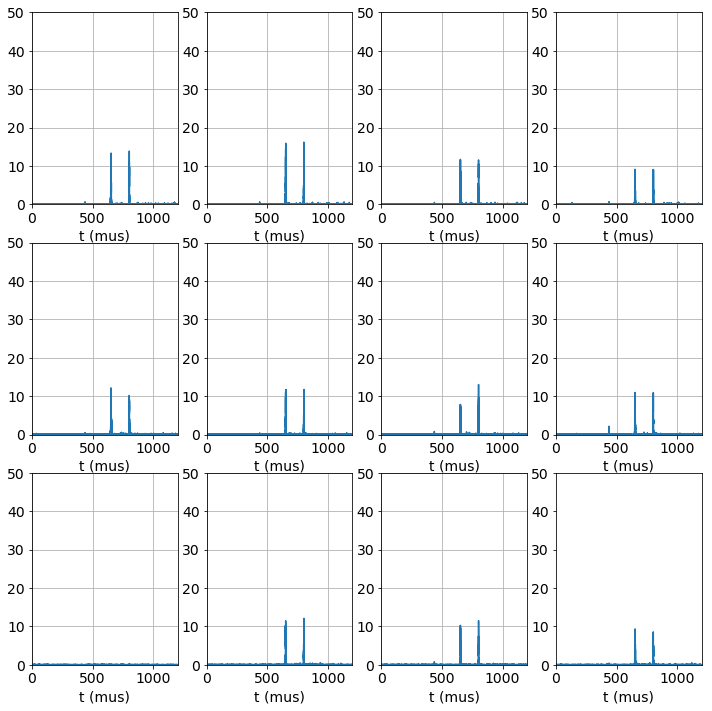

In [54]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 1200,
                                signal_min =    0,
                                signal_max =  50,
                                 figsize=(12,12))

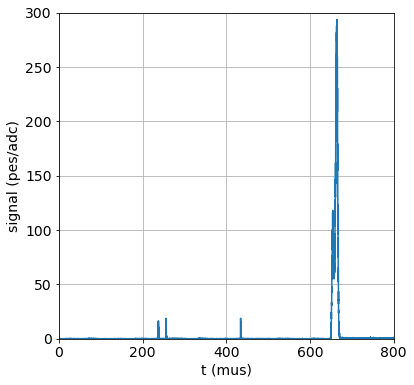

In [86]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 800,
                            signal_min =    0,
                            signal_max =  300,
                            figsize=(6,6))

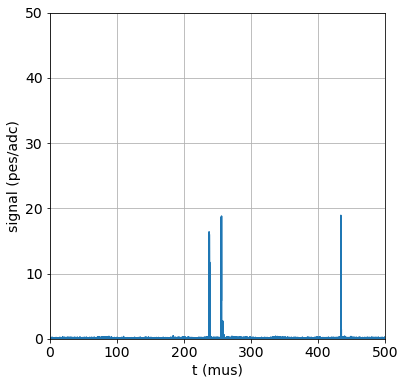

In [87]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 500,
                            signal_min =    0,
                            signal_max =  50,
                            figsize=(6,6))

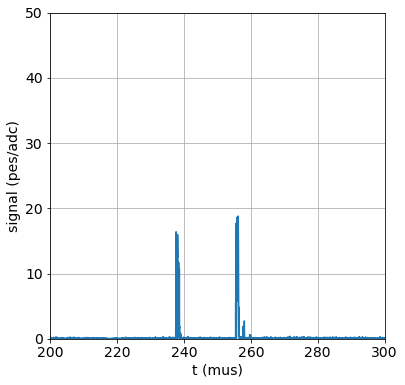

In [90]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =200,
                            t_max      = 300,
                            signal_min =    0,
                            signal_max =  50,
                            figsize=(6,6))

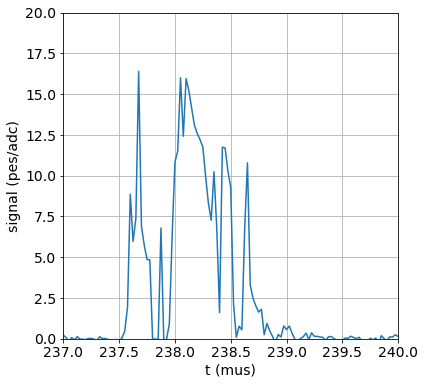

In [93]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =237,
                            t_max      = 240,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

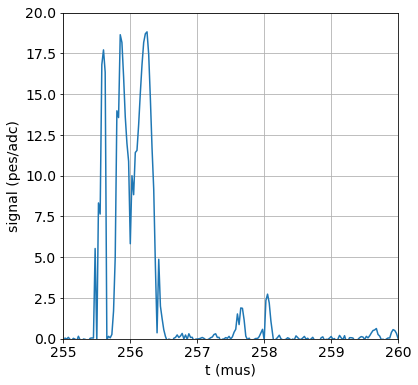

In [96]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =255,
                            t_max      = 260,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

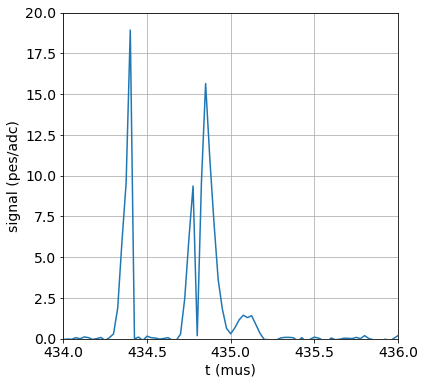

In [99]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =434,
                            t_max      = 436,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

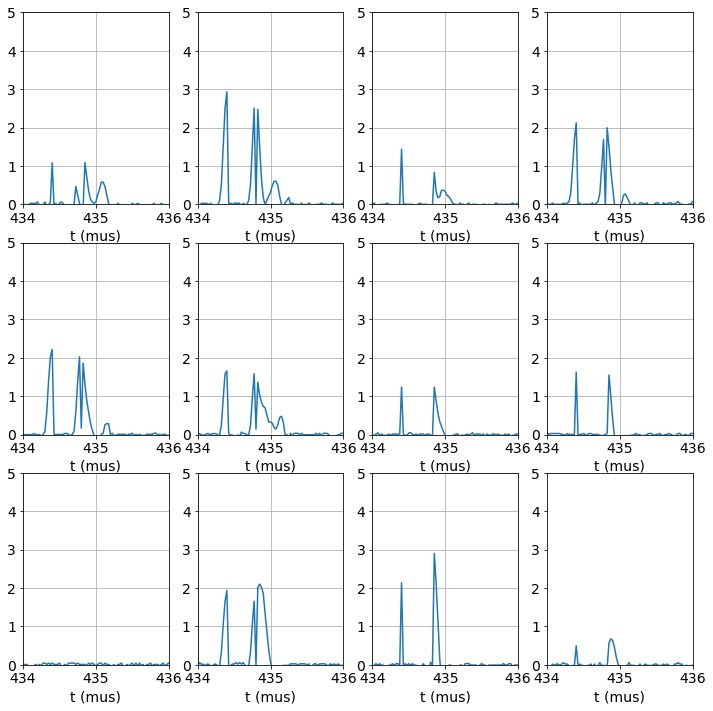

In [101]:
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    434,
                                t_max      = 436,
                                signal_min =    0,
                                signal_max =  5,
                                 figsize=(12,12))

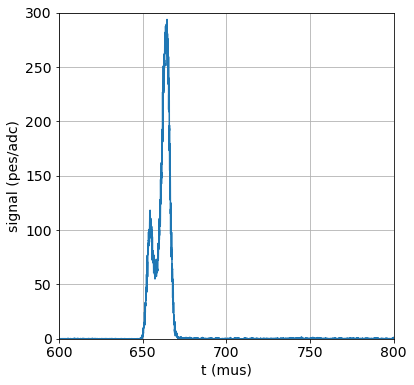

In [88]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 800,
                            signal_min =    0,
                            signal_max =  300,
                            figsize=(6,6))

In [105]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 2.0 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 255.475  255.5    255.525  255.55   255.575  255.6    255.625] µs
 Time @ max energy: 255.6
 Width: 0.15 µs
 Height: 17.71671792148105 pes
 Energy: 72.39555845508693 pes
 Charge: 0.0 pes
 RMS: 0.042828630462381126 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 434.725  434.75   434.775  434.8    434.825  434.85   434.875  434.9
 434.925  434.95 ] µs
       Time @ max energy: 434.85
       Width: 0.225 µs
       Height: 15.651027337791723 pes
       Energy: 66.9804583791108 pes
       Charge: 0.0 pes
       RMS: 0.05633933109081544 µs]

- Several scintillation signals.
- The likely S1 is at 434 and shows "peak duplication".
- The scintillation signals are wider than S1 

In [106]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 22
       Times: [ 650.40360736  651.34858645  652.32124808  653.29492178  654.27786655
 655.2433575   656.23962937  657.25000897  658.26684403  659.29384852
 660.28756446  661.29158052  662.29005856  663.27590731  664.2636865
 665.24337346  666.20874439  667.20510329  668.17028377  669.16325432
 670.2434243   670.91785065] µs
       Time @ max energy: 664.2636864958351
       Width: 20.514243288762984 µs
       Height: 11218.910292185823 pes
       Energy: 88367.38196548082 pes
       Charge: 0.0 pes
       RMS: 4.32957209623818 µs]

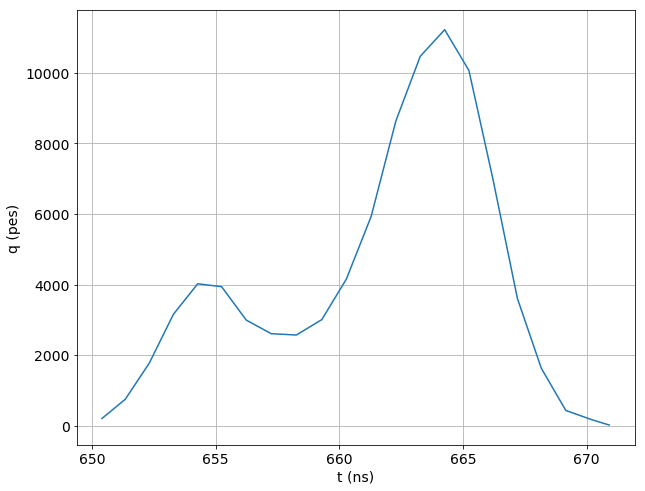

In [108]:
plot_S12(s2s)

## Event 2

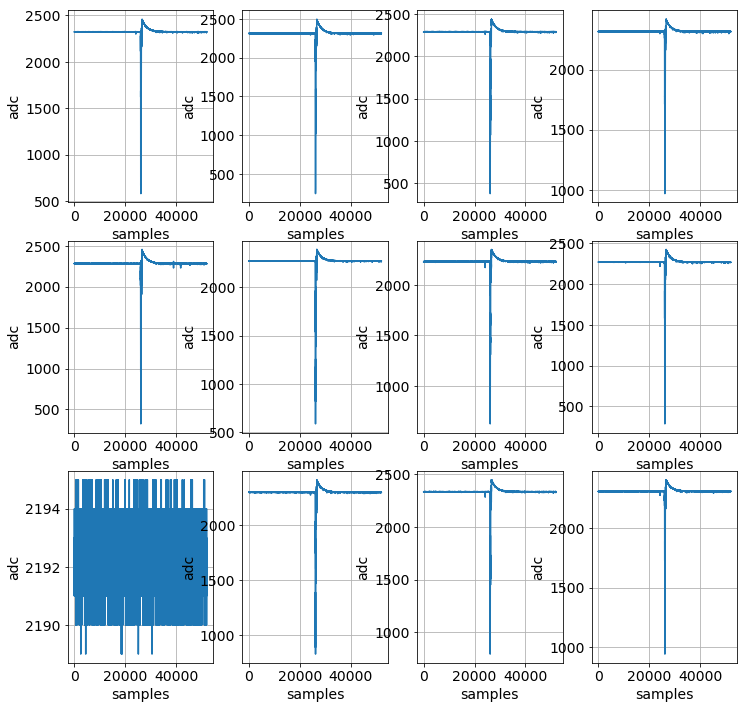

In [109]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

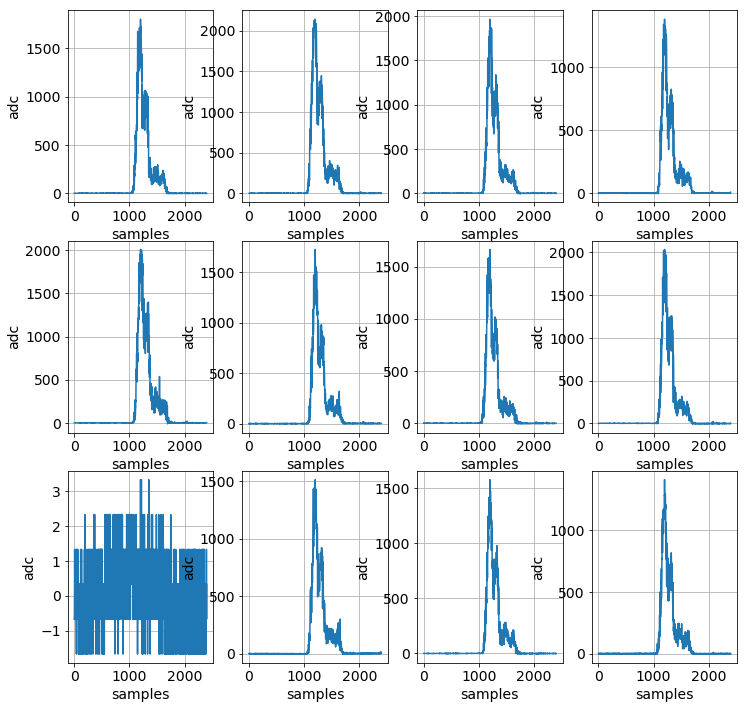

In [110]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

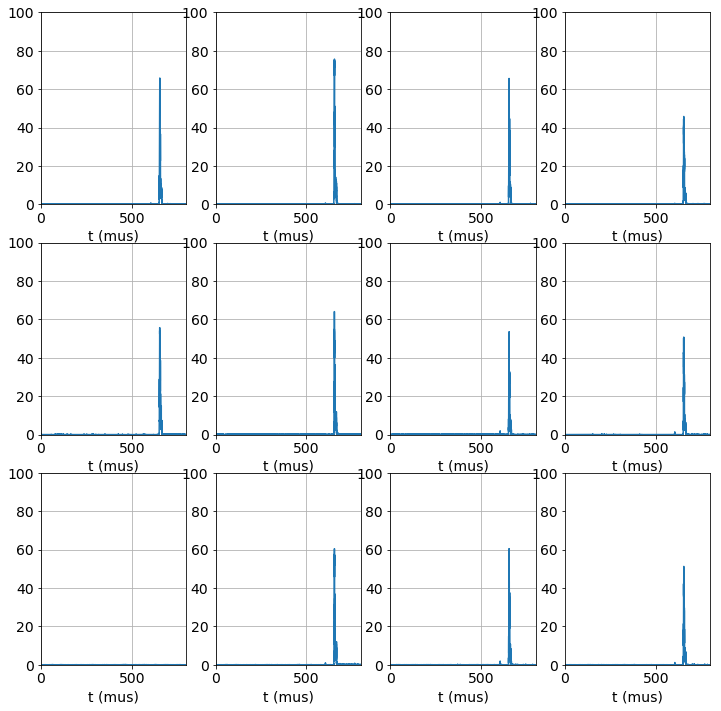

In [113]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 800,
                                signal_min =    0,
                                signal_max =  100,
                                 figsize=(12,12))

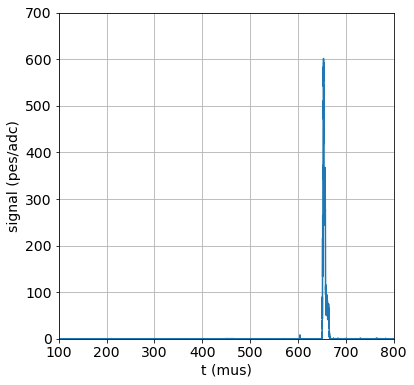

In [118]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 800,
                            signal_min =    0,
                            signal_max =  700,
                            figsize=(6,6))

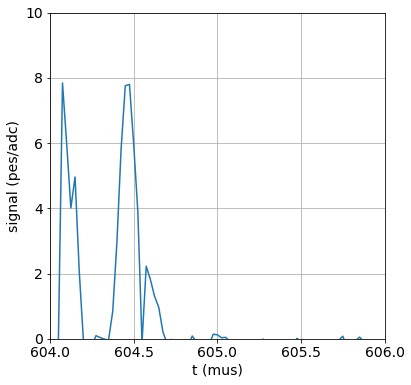

In [121]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =604,
                            t_max      = 606,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [122]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 2.0 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 604.075  604.1    604.125  604.15 ] µs
 Time @ max energy: 604.075
 Width: 0.075 µs
 Height: 7.840444523744921 pes
 Energy: 22.790311595209637 pes
 Charge: 0.0 pes
 RMS: 0.028716583390007964 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 604.4    604.425  604.45   604.475  604.5    604.525  604.55   604.575] µs
 Time @ max energy: 604.475
 Width: 0.175 µs
 Height: 7.799814945249787 pes
 Energy: 36.43140742170603 pes
 Charge: 0.0 pes
 RMS: 0.044212284080757114 µs]

- Double S1

In [123]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 17
       Times: [ 650.81930917  651.72023237  652.68585989  653.63551678  654.58036958
 655.65914302  656.62537058  657.5318696   658.59232209  659.6645355
 660.62308435  661.60927667  662.65020259  663.66342413  664.57077104
 665.48141793  666.26925375] µs
       Time @ max energy: 653.635516780874
       Width: 15.449944574909633 µs
       Height: 22916.671085679707 pes
       Energy: 113535.11349443407 pes
       Charge: 0.0 pes
       RMS: 3.1355905945962257 µs]

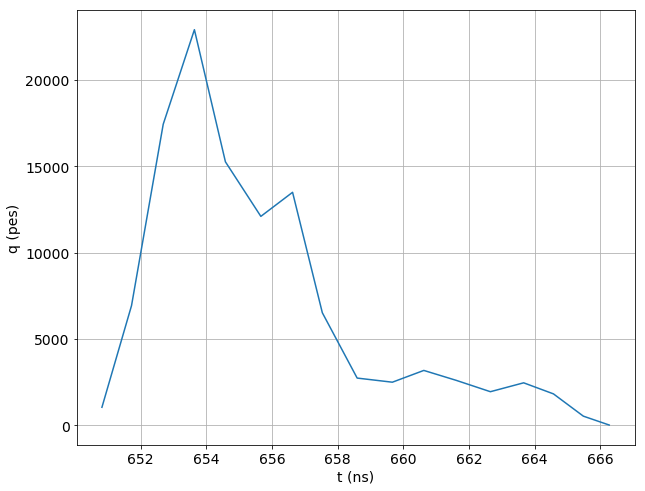

In [124]:
plot_S12(s2s)

- Double S1

## Event 3

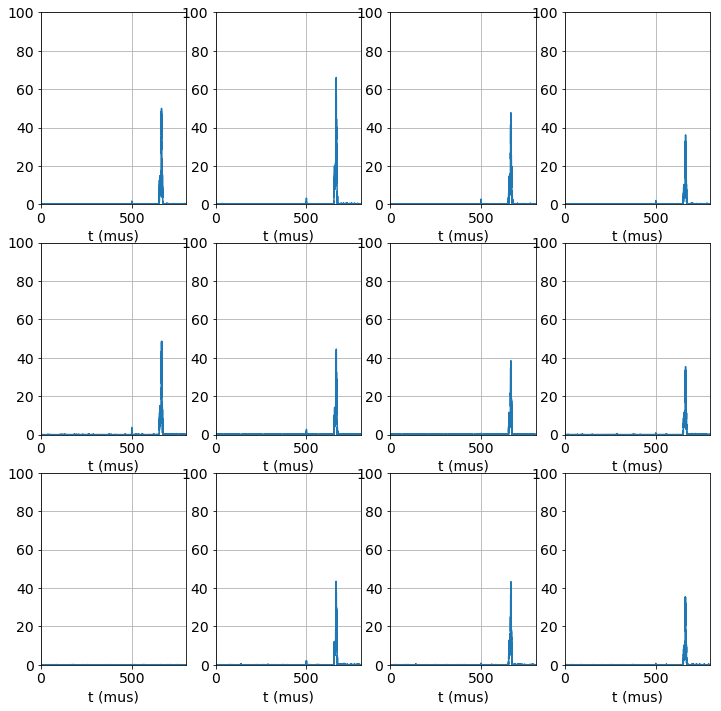

In [127]:
event=3
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 800,
                                signal_min =    0,
                                signal_max =  100,
                                 figsize=(12,12))

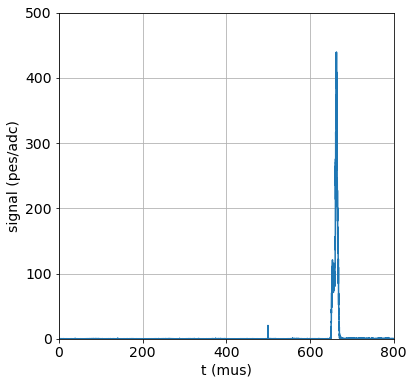

In [130]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 800,
                            signal_min =    0,
                            signal_max =  500,
                            figsize=(6,6))

In [132]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 2.0 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 499.35   499.375  499.4    499.425  499.45 ] µs
 Time @ max energy: 499.35
 Width: 0.1 µs
 Height: 7.226741608763009 pes
 Energy: 16.571814388768367 pes
 Charge: 0.0 pes
 RMS: 0.034439711923847344 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 499.625  499.65   499.675  499.7    499.725  499.75   499.775  499.8
 499.825  499.85 ] µs
       Time @ max energy: 499.7
       Width: 0.225 µs
       Height: 20.418316823879337 pes
       Energy: 104.20223896664356 pes
       Charge: 0.0 pes
       RMS: 0.05080238086895848 µs]

In [133]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 1.0 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 499.35   499.375  499.4    499.425  499.45   499.475] µs
 Time @ max energy: 499.35
 Width: 0.125 µs
 Height: 7.226741608763009 pes
 Energy: 17.87418219506528 pes
 Charge: 0.0 pes
 RMS: 0.04124475491622392 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 499.6    499.625  499.65   499.675  499.7    499.725  499.75   499.775
 499.8    499.825  499.85   499.875] µs
       Time @ max energy: 499.7
       Width: 0.275 µs
       Height: 20.418316823879337 pes
       Energy: 107.38519795383922 pes
       Charge: 0.0 pes
       RMS: 0.055120888412473375 µs]

In [134]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 23
       Times: [ 499.35   499.375  499.4    499.425  499.45   499.475  499.5    499.525
 499.55   499.575  499.6    499.625  499.65   499.675  499.7    499.725
 499.75   499.775  499.8    499.825  499.85   499.875  499.9  ] µs
       Time @ max energy: 499.7
       Width: 0.55 µs
       Height: 20.418316823879337 pes
       Energy: 126.87339193208686 pes
       Charge: 0.0 pes
       RMS: 0.12477641269498062 µs]

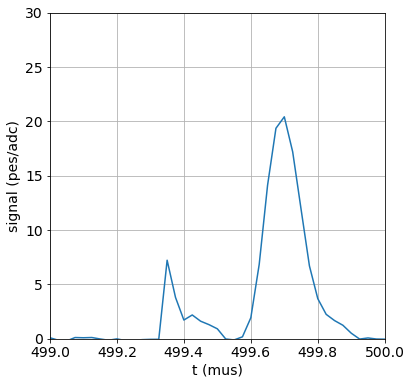

In [137]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =499,
                            t_max      = 500,
                            signal_min =    0,
                            signal_max =  30,
                            figsize=(6,6))

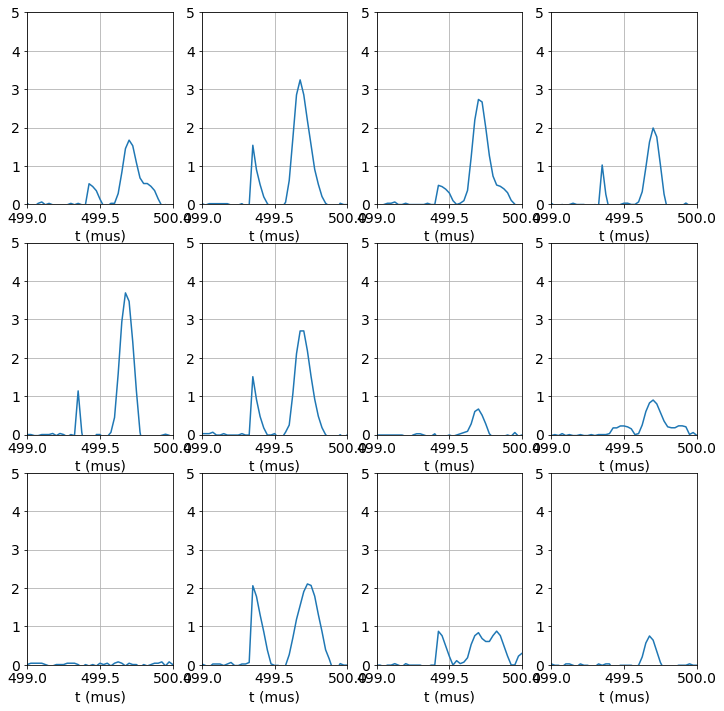

In [139]:
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    499,
                                t_max      = 500,
                                signal_min =    0,
                                signal_max =  5,
                                 figsize=(12,12))

- double peak structure

In [140]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 23
       Times: [ 649.98312322  650.93209229  651.85290425  652.84057754  653.81297963
 654.79885122  655.80831167  656.82024534  657.8017269   658.80316835
 659.83639513  660.87501608  661.84345901  662.81948981  663.79056685
 664.78806302  665.79358368  666.79511529  667.78677239  668.74250442
 669.73400195  670.64584106  671.6950396 ] µs
       Time @ max energy: 662.8194898136542
       Width: 21.711916382760858 µs
       Height: 16110.92801298772 pes
       Energy: 118010.30674780077 pes
       Charge: 0.0 pes
       RMS: 4.311047618658868 µs]

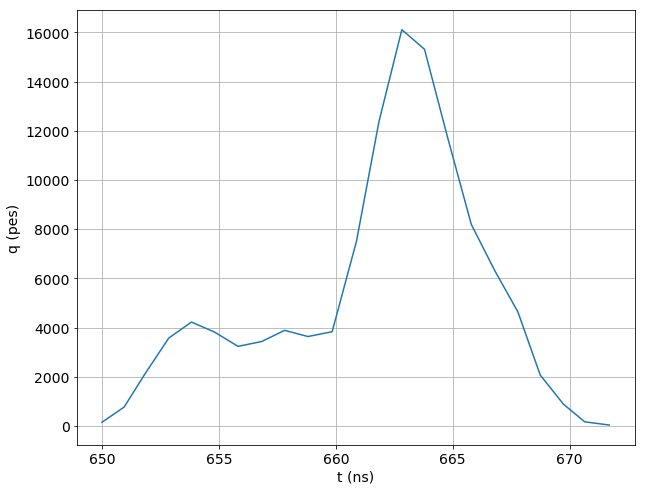

In [141]:
plot_S12(s2s)

## Event 4

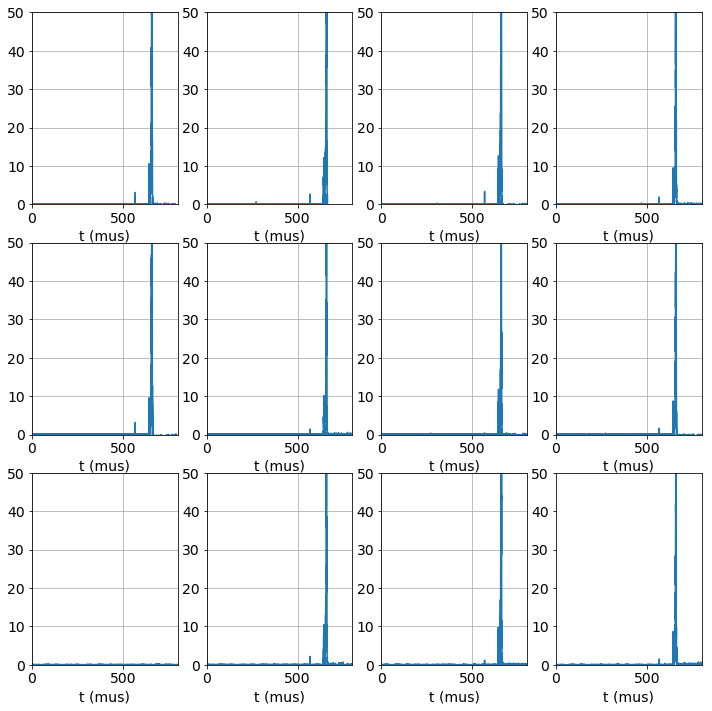

In [143]:
event=4
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 800,
                                signal_min =    0,
                                signal_max =  50,
                                 figsize=(12,12))

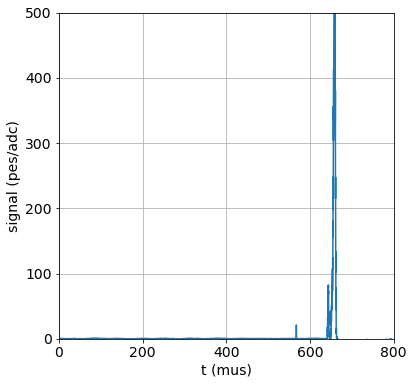

In [144]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 800,
                            signal_min =    0,
                            signal_max =  500,
                            figsize=(6,6))

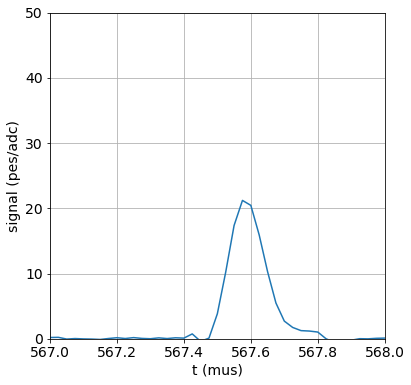

In [146]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =567,
                            t_max      = 568,
                            signal_min =    0,
                            signal_max =  50,
                            figsize=(6,6))

In [145]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 18
       Times: [ 567.375  567.4    567.425  567.45   567.475  567.5    567.525  567.55
 567.575  567.6    567.625  567.65   567.675  567.7    567.725  567.75
 567.775  567.8  ] µs
       Time @ max energy: 567.575
       Width: 0.425 µs
       Height: 21.21351109649187 pes
       Energy: 113.851150552782 pes
       Charge: 0.0 pes
       RMS: 0.060369376102830795 µs]

In [147]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 24
       Times: [ 641.38406968  642.2502221   643.16849904  644.10816965  645.03660588
 646.01874487  646.9120125   648.08374119  649.27711836  650.19661306
 651.18762925  652.13428091  653.11979142  654.14841491  655.15880596
 656.15055731  657.1560834   658.13570329  659.10814236  660.08435759
 661.04343595  662.02617294  662.95044621  664.15888172] µs
       Time @ max energy: 659.1081423584139
       Width: 21.566376527704413 µs
       Height: 29679.515247068135 pes
       Energy: 150146.6319748488 pes
       Charge: 0.0 pes
       RMS: 3.8053752185795737 µs]

- We see the effect of the double S1
- If the S2 is Krypton, with 13,000 pes, this suggests lifetime quite good. 

## Event 6

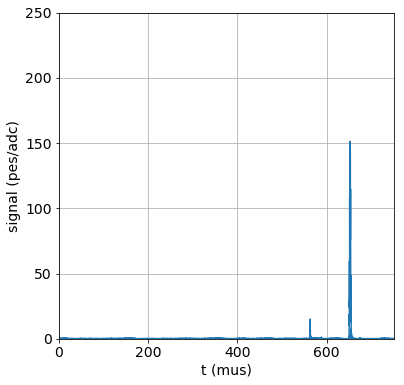

In [198]:
event=6
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [205]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 564.4    564.425  564.45   564.475  564.5  ] µs
 Time @ max energy: 564.45
 Width: 0.1 µs
 Height: 2.1724625353683518 pes
 Energy: 7.824691234799927 pes
 Charge: 0.0 pes
 RMS: 0.030121085453369993 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 587.425  587.45   587.475  587.5    587.525] µs
 Time @ max energy: 587.525
 Width: 0.1 µs
 Height: 1.1191144011508507 pes
 Energy: 4.335075931971086 pes
 Charge: 0.0 pes
 RMS: 0.03449075196923004 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 587.825  587.85   587.875  587.9    587.925  587.95   587.975  588.
 588.025  588.05 ] µs
       Time @ max energy: 587.875
       Width: 0.225 µs
       Height: 1.188889752282432 pes
       Energy: 5.412232415183533 pes
       Charge: 0.0 pes
       RMS: 0.06826510971087754 µs]

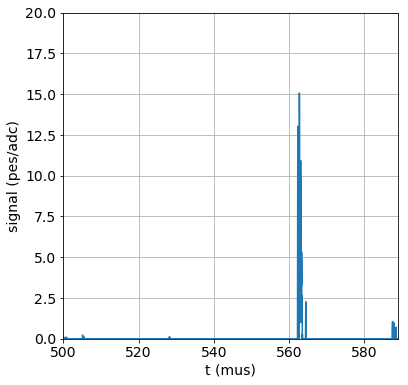

In [208]:
sf.plot_signal_vs_time_mus(cwf_sum_mau,
                            t_min      =500,
                            t_max      = 589,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

In [148]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 6
       Times: [ 642.04081666  642.97910596  643.91935845  644.82563154  645.76603185
 646.67393869] µs
       Time @ max energy: 643.9193584525573
       Width: 4.633122038730187 µs
       Height: 3014.866783003269 pes
       Energy: 7557.552516188807 pes
       Charge: 0.0 pes
       RMS: 0.9357929449994474 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 16
       Times: [ 650.01518201  651.01756359  651.92875969  652.92951798  653.95660359
 654.96339741  655.95735498  656.95063852  657.93754563  658.91598646
 659.89031333  660.83417224  661.80054475  662.74265047  659.74756821
 664.75717439] µs
       Time @ max energy: 658.9159864588411
       Width: 14.741992381437216 µs
       Height: 29759.00234046345 pes
       Energy: 142506.74257095665 pes
       Charge: 0.0 pes
       RMS: 2.202006746252374 µs]

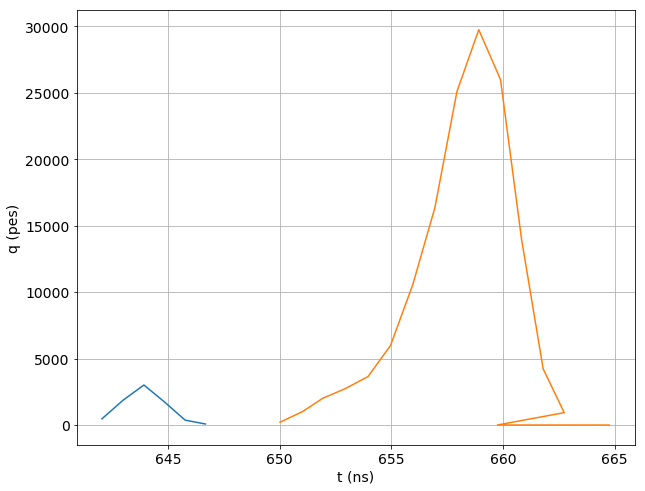

In [149]:
plot_S12(s2s)

In [150]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 7
       Times: [ 641.5105443   642.38728443  643.3078156   644.22947372  645.16579532
 646.20025251  646.9732671 ] µs
       Time @ max energy: 644.229473721932
       Width: 5.462722803629585 µs
       Height: 2875.0657309571093 pes
       Energy: 7575.60795509964 pes
       Charge: 0.0 pes
       RMS: 0.9460184374977346 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 16
       Times: [ 649.51488461  650.4357135   651.37039055  652.34310623  653.33066965
 654.35164936  655.35946457  656.34153196  657.34883804  658.32776807
 659.30418746  660.26502691  661.21984961  662.21826323  663.15024096
 664.04074062] µs
       Time @ max energy: 659.3041874586362
       Width: 13.635356355301221 µs
       Height: 29325.134966767328 pes
       Energy: 142555.7647950436 pes
       Charge: 0.0 pes
       RMS: 2.205746600897016 µs]

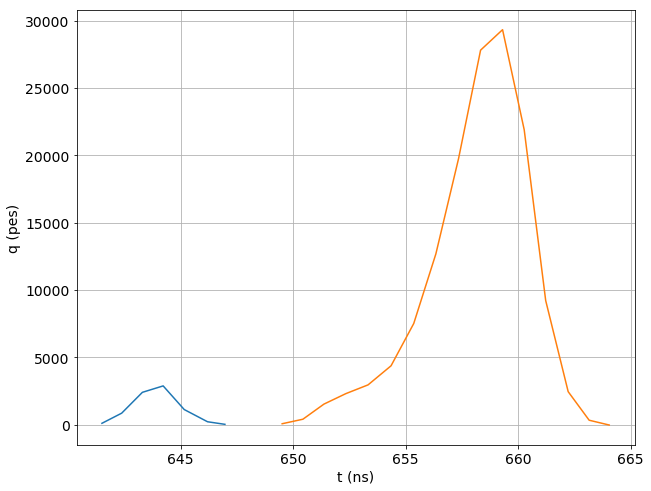

In [151]:
plot_S12(s2s)

In [152]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 24
       Times: [ 641.38406968  642.2502221   643.16849904  644.10816965  645.03660588
 646.01874487  646.9120125   648.08374119  649.27711836  650.19661306
 651.18762925  652.13428091  653.11979142  654.14841491  655.15880596
 656.15055731  657.1560834   658.13570329  659.10814236  660.08435759
 661.04343595  662.02617294  662.95044621  664.15888172] µs
       Time @ max energy: 659.1081423584139
       Width: 21.566376527704413 µs
       Height: 29679.515247068135 pes
       Energy: 150146.6319748488 pes
       Charge: 0.0 pes
       RMS: 3.8053752185795737 µs]

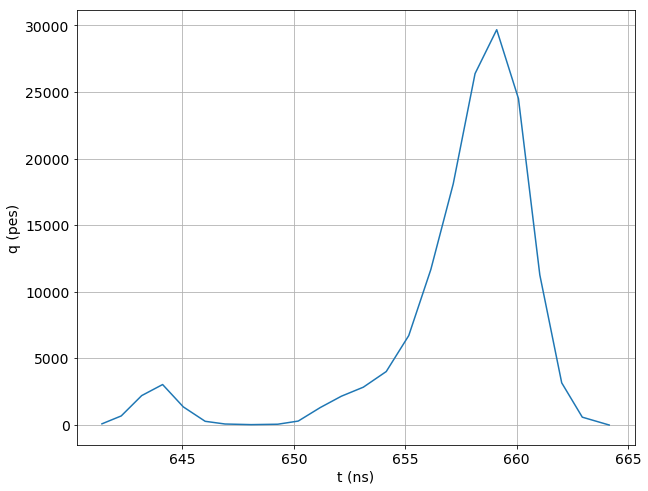

In [153]:
plot_S12(s2s)

- One has to be careful with the S2 threshold. Setting it low (0.5 pes) may result in "inventing" small clusters but setting it higher may split the main track, thus affecting the energy resolution. Thus, the setting of the threshold has to be small, and eventually tolerate more than 1 S2.

## Event 7

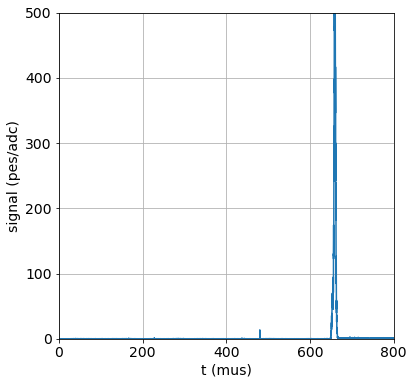

In [155]:
event=7
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 800,
                            signal_min =    0,
                            signal_max =  500,
                            figsize=(6,6))

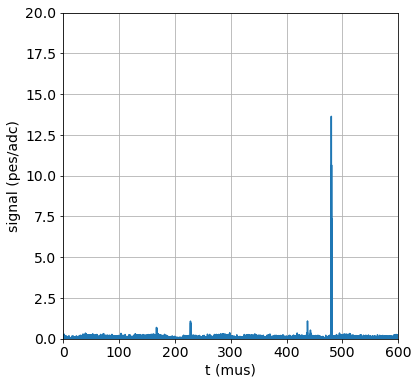

In [157]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

In [156]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 166.95   166.975  167.     167.025] µs
 Time @ max energy: 166.95
 Width: 0.075 µs
 Height: 0.6956102570891477 pes
 Energy: 2.55411969623166 pes
 Charge: 0.0 pes
 RMS: 0.02814642964111766 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 167.35   167.375  167.4    167.425] µs
 Time @ max energy: 167.4
 Width: 0.075 µs
 Height: 0.6552732887397688 pes
 Energy: 2.347646575961232 pes
 Charge: 0.0 pes
 RMS: 0.0267607243973142 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 228.05   228.075  228.1    228.125  228.15   228.175  228.2    228.225] µs
 Time @ max energy: 228.225
 Width: 0.175 µs
 Height: 0.9777845852440988 pes
 Energy: 4.560347645238133 pes
 Charge: 0.0 pes
 RMS: 0.06612810362110279 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 437.575  437.6    

In [158]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 1.0 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 480.25   480.275  480.3    480.325  480.35 ] µs
 Time @ max energy: 480.25
 Width: 0.1 µs
 Height: 13.640051889406891 pes
 Energy: 31.178567627278657 pes
 Charge: 0.0 pes
 RMS: 0.031647639200783804 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 480.575  480.6    480.625  480.65   480.675  480.7    480.725  480.75
 480.775  480.8    480.825  480.85 ] µs
       Time @ max energy: 480.675
       Width: 0.275 µs
       Height: 10.65552786065641 pes
       Energy: 51.77525039822194 pes
       Charge: 0.0 pes
       RMS: 0.07207038201961549 µs]

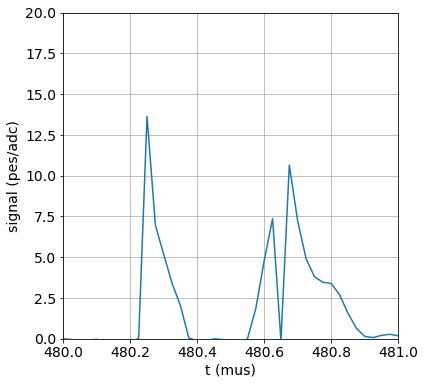

In [160]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =480,
                            t_max      = 481,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

- double peak and small scintillation 

In [161]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 22
       Times: [ 649.6465469   650.65559156  651.58428465  652.61712612  653.54431652
 654.51040431  655.5715117   656.59569107  657.5978274   658.56489565
 659.53525513  660.50527343  661.48131586  662.47291588  663.47846373
 664.42844037  665.41493699  666.50877266  667.43031757  668.61083529
 669.46547961  670.24865264] µs
       Time @ max energy: 659.5352551307815
       Width: 20.602105746101937 µs
       Height: 22692.374672843776 pes
       Energy: 108971.41721815582 pes
       Charge: 0.0 pes
       RMS: 2.3540680551460063 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 4
 Times: [ 675.88743721  676.8980271   677.84241953  678.60339728] µs
 Time @ max energy: 675.8874372123927
 Width: 2.7159600656095426 µs
 Height: 19.989185497054795 pes
 Energy: 50.94753399004763 pes
 Charge: 0.0 pes
 RMS: 0.9913395383026491 µs, 
 ---------------------

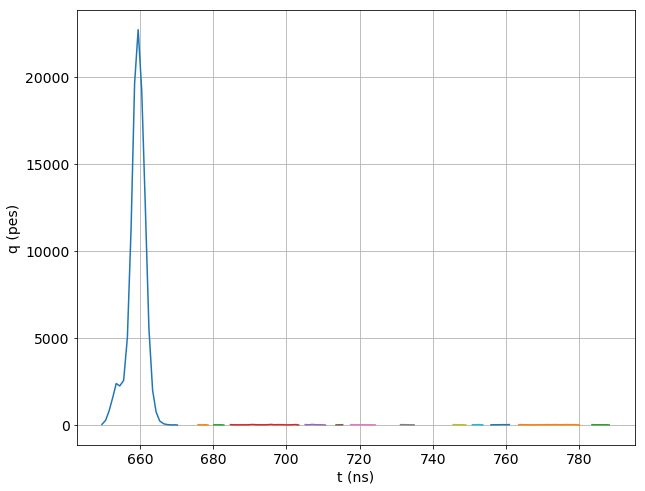

In [162]:
plot_S12(s2s)

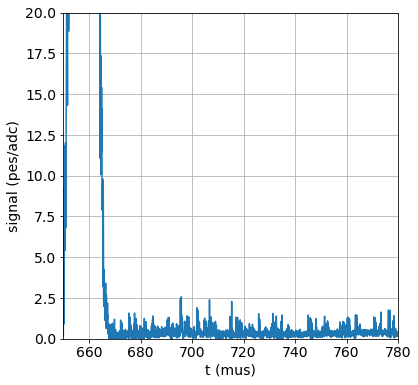

In [164]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =650,
                            t_max      = 780,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

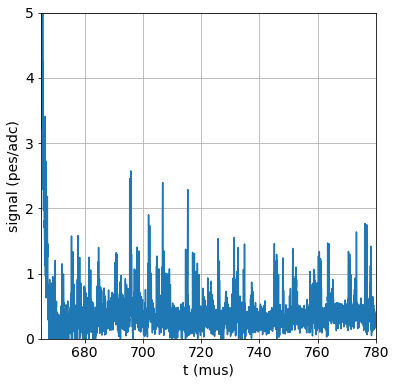

In [168]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =665,
                            t_max      = 780,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

- The baseline recovery and the grass makes than one has to cut at least in 1 pes. 

- grass contributes to create a fake signal 

In [165]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 18
       Times: [ 649.94813884  650.95731136  651.91946616  652.90679637  653.85423212
 654.85194979  655.9177852   656.92977213  657.91681051  658.87853394
 659.85364746  660.83257454  661.79257278  662.77446519  663.79068511
 664.79949616  665.71285594  666.77272693] µs
       Time @ max energy: 659.8536474596154
       Width: 16.824588092423394 µs
       Height: 22306.78888080197 pes
       Energy: 108934.7997012289 pes
       Charge: 0.0 pes
       RMS: 2.347713683170805 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 4
 Times: [ 695.85125645  697.02894116  697.92878152  698.57893344] µs
 Time @ max energy: 695.8512564530062
 Width: 2.7276769904886606 µs
 Height: 37.14018286387481 pes
 Energy: 84.55732981318529 pes
 Charge: 0.0 pes
 RMS: 1.0239311239898792 µs]

In [166]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 18
       Times: [ 650.07904207  651.0330044   651.99893247  652.98237192  653.93050513
 654.93281011  655.99384158  657.00863162  657.99226885  658.95203858
 659.9287493   660.9095813   661.86866745  662.84708728  663.85249631
 664.87681931  665.81596284  666.76849161] µs
       Time @ max energy: 659.9287493013428
       Width: 16.68944953844941 µs
       Height: 22127.07364981484 pes
       Energy: 108924.11354275275 pes
       Charge: 0.0 pes
       RMS: 2.3463357310559094 µs]

## Event 8

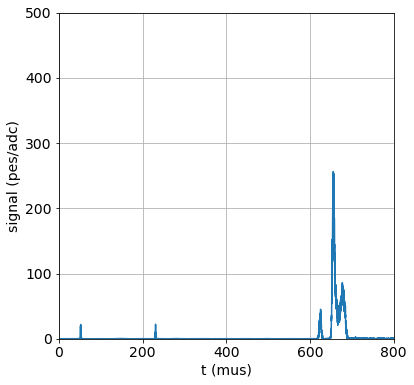

In [169]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 800,
                            signal_min =    0,
                            signal_max =  500,
                            figsize=(6,6))

In [174]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 600 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 1.0 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 51.825  51.85   51.875  51.9    51.925] µs
 Time @ max energy: 51.85
 Width: 0.1 µs
 Height: 19.825485030552027 pes
 Energy: 61.66800747049521 pes
 Charge: 0.0 pes
 RMS: 0.03302704657375744 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 230.7    230.725  230.75   230.775  230.8    230.825  230.85   230.875
 230.9  ] µs
       Time @ max energy: 230.775
       Width: 0.2 µs
       Height: 10.914680711658017 pes
       Energy: 56.78652450941406 pes
       Charge: 0.0 pes
       RMS: 0.04783818382932736 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 231.1    231.125  231.15   231.175  231.2    231.225  231.25   231.275
 231.3    231.325  231.35   231.375] µs
       Time @ max energy: 231.175
       Width: 0.275 µs
       Height: 22.241716316

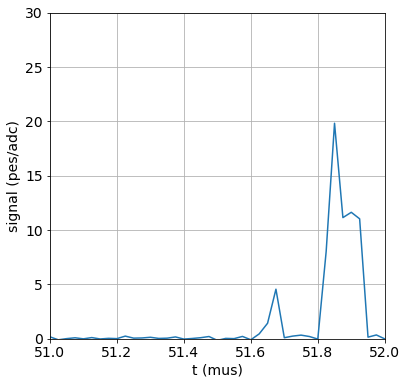

In [176]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =51,
                            t_max      = 52,
                            signal_min =    0,
                            signal_max =  30,
                            figsize=(6,6))

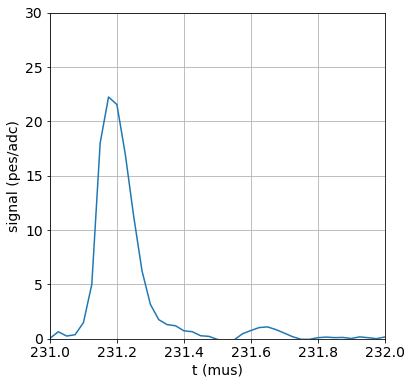

In [177]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =231,
                            t_max      = 232,
                            signal_min =    0,
                            signal_max =  30,
                            figsize=(6,6))

In [173]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 46
       Times: [ 648.46590342  649.50767526  650.48035748  651.49248884  652.44451245
 653.4427877   654.43961837  655.42252975  656.41057145  657.39595061
 658.38262597  659.38694178  660.387483    661.40837253  662.39880774
 663.41282701  664.40303934  665.38153514  666.40980085  667.39907624
 668.42232309  669.42180112  670.41127087  671.42117373  672.437984
 673.41567235  674.42997696  675.41190345  676.42486452  677.42054902
 678.40868921  679.39882874  680.4298207   681.40342747  682.42342912
 683.40199913  684.39166656  685.37820821  686.36247306  687.38211261
 688.28409523  689.30468194  690.24593011  691.3287299   692.56966035
 693.12498301] µs
       Time @ max energy: 656.410571445987
       Width: 44.65907958980871 µs
       Height: 9515.755207501717 pes
       Energy: 108750.6798869741 pes
       Charge: 0.0 pes
       RMS: 10.385924294338196 µs]

## Event 9

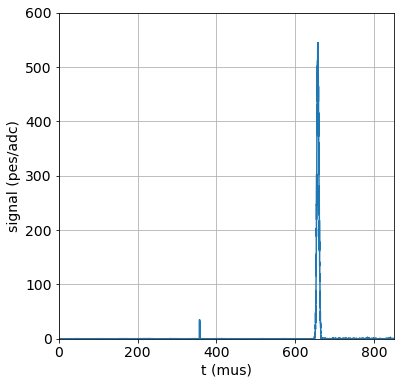

In [180]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 850,
                            signal_min =    0,
                            signal_max =  600,
                            figsize=(6,6))

In [186]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 1 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 357.25   357.275  357.3    357.325  357.35   357.375  357.4    357.425
 357.45   357.475  357.5    357.525] µs
       Time @ max energy: 357.325
       Width: 0.275 µs
       Height: 35.134806914880926 pes
       Energy: 76.32462316387641 pes
       Charge: 0.0 pes
       RMS: 0.06293422975423 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 357.65   357.675  357.7    357.725  357.75   357.775  357.8    357.825
 357.85   357.875  357.9    357.925] µs
       Time @ max energy: 357.75
       Width: 0.275 µs
       Height: 32.542459197994255 pes
       Energy: 150.082756764937 pes
       Charge: 0.0 pes
       RMS: 0.0607843791325884 µs]

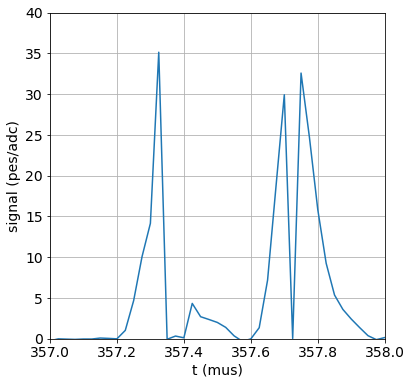

In [185]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =357,
                            t_max      = 358,
                            signal_min =    0,
                            signal_max =  40,
                            figsize=(6,6))

In [187]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 600 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 40),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s


[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 33
       Times: [ 357.225  357.25   357.275  357.3    357.325  357.35   357.375  357.4
 357.425  357.45   357.475  357.5    357.525  357.55   357.575  357.6
 357.625  357.65   357.675  357.7    357.725  357.75   357.775  357.8
 357.825  357.85   357.875  357.9    357.925  357.95   357.975  358.
 358.025] µs
       Time @ max energy: 357.325
       Width: 0.8 µs
       Height: 35.134806914880926 pes
       Energy: 229.02300261548075 pes
       Charge: 0.0 pes
       RMS: 0.20871620498283844 µs]

- This suggests that the structure of S1 is totally modified by the electronics. Lowering the threshold we record a signal of 0.8 mus, which shows several peaks but is consistent with arising from a single S1. 

In [188]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 20
       Times: [ 649.19344386  650.08628092  651.09100053  652.09010196  653.0859121
 654.06261226  655.0507668   656.03168638  657.02379155  658.00478856
 658.9971165   659.98495964  660.97509361  661.982723    662.95855892
 663.94062121  664.88544769  665.92876777  667.07356201  667.837263  ] µs
       Time @ max energy: 658.004788563163
       Width: 18.643819142288297 µs
       Height: 20504.1895769474 pes
       Energy: 140865.22378831598 pes
       Charge: 0.0 pes
       RMS: 2.6426077844354383 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 3
 Times: [ 672.22947803  673.31430824  673.8838113 ] µs
 Time @ max energy: 673.883811298221
 Width: 0.0 µs
 Height: -7.0357394396042405 pes
 Energy: 0.0 pes
 Charge: 0.0 pes
 RMS: 0.0 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 5
 Times: [ 695.45211132  696.883

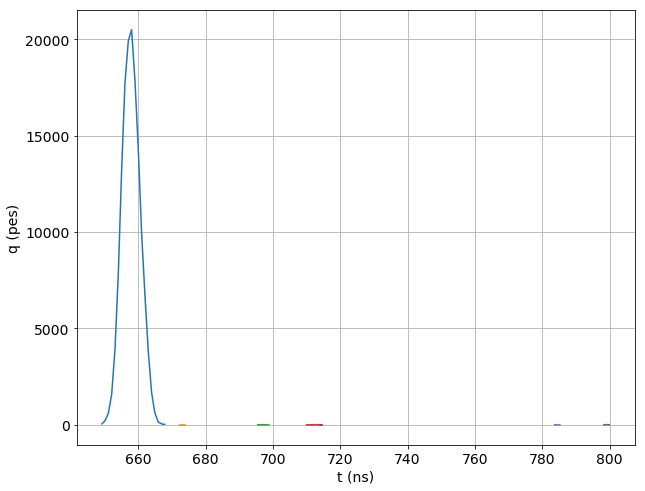

In [189]:
plot_S12(s2s)

In [190]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 20
       Times: [ 649.52385649  650.50091246  651.4980322   652.47779675  653.46276369
 654.45021904  655.43376501  656.42225363  657.41565346  658.39985947
 659.39298463  660.38108333  661.37267103  662.37062439  663.34716738
 664.35086327  665.27129756  666.2322388   667.46081731  668.06734586] µs
       Time @ max energy: 657.4156534564138
       Width: 18.543489364667796 µs
       Height: 20676.198953144936 pes
       Energy: 140858.24840266976 pes
       Charge: 0.0 pes
       RMS: 2.6415442559061 µs]

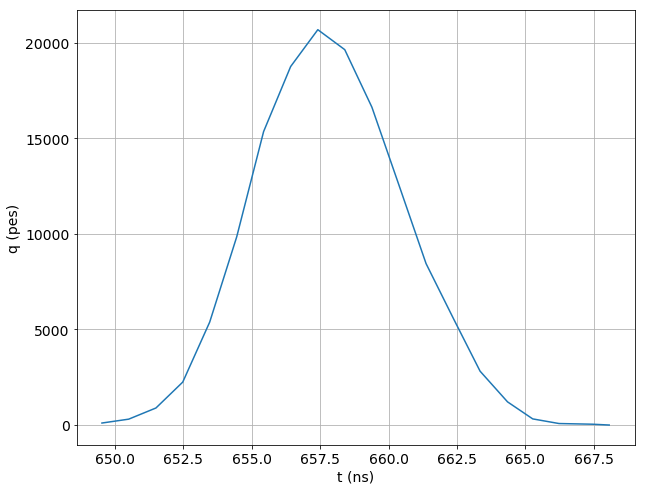

In [191]:
plot_S12(s2s)

## Event 10

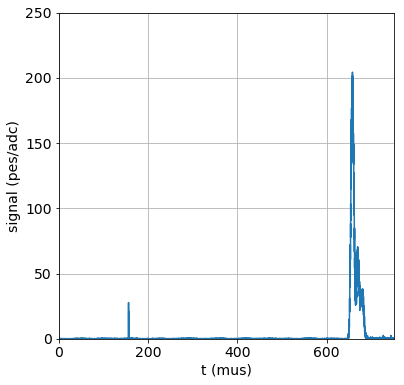

In [192]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [193]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 600 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 40),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 15
       Times: [ 156.5    156.525  156.55   156.575  156.6    156.625  156.65   156.675
 156.7    156.725  156.75   156.775  156.8    156.825  156.85 ] µs
       Time @ max energy: 156.55
       Width: 0.35 µs
       Height: 21.165060568547467 pes
       Energy: 91.44634260129854 pes
       Charge: 0.0 pes
       RMS: 0.08813870300604712 µs]

In [194]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 40
       Times: [ 648.77546634  649.90549295  650.83368285  651.8062668   652.77330553
 653.78115051  654.76649423  655.74840229  656.73617936  657.74190247
 658.71908732  659.72871458  660.71609936  661.70166385  662.6940048
 663.71274809  664.7320646   665.75386938  666.74720232  667.75974351
 668.74441231  669.73821066  670.72311859  671.72315667  672.71615939
 673.7109626   674.73001713  675.76071951  676.7316431   677.74500081
 678.71599002  679.74407368  680.73041868  681.74122703  682.68090011
 683.72869273  684.69321904  685.66328757  686.72513301  687.60088202] µs
       Time @ max energy: 657.741902468011
       Width: 38.82541567668074 µs
       Height: 7324.368255564716 pes
       Energy: 90005.83254664783 pes
       Charge: 0.0 pes
       RMS: 8.448636743954557 µs]

## Event 11

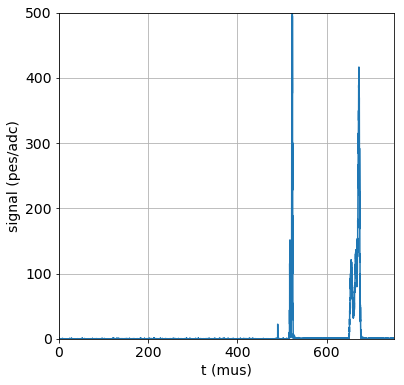

In [196]:
event=11
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  500,
                            figsize=(6,6))

## Event 12

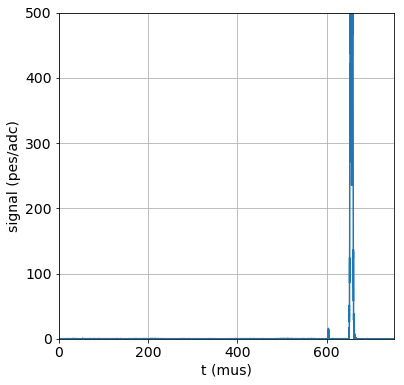

In [200]:
event=12
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  500,
                            figsize=(6,6))

In [201]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 610 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 40),  #250 ns -- 50 ns
                           rebin_stride  = 1)


s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 603.825  603.85   603.875  603.9    603.925  603.95   603.975  604.   ] µs
 Time @ max energy: 603.9
 Width: 0.175 µs
 Height: 16.03495329481645 pes
 Energy: 54.56470097896546 pes
 Charge: 0.0 pes
 RMS: 0.044103290202209246 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 14
       Times: [ 604.225  604.25   604.275  604.3    604.325  604.35   604.375  604.4
 604.425  604.45   604.475  604.5    604.525  604.55 ] µs
       Time @ max energy: 604.275
       Width: 0.325 µs
       Height: 14.364300679109686 pes
       Energy: 69.69395457673625 pes
       Charge: 0.0 pes
       RMS: 0.07520776781217113 µs]

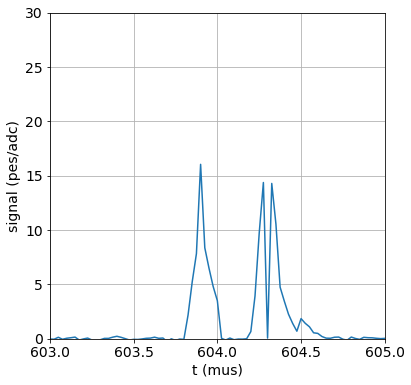

In [203]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =603,
                            t_max      = 605,
                            signal_min =    0,
                            signal_max =  30,
                            figsize=(6,6))

In [204]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 650.21585902  651.16485544  652.0694876   653.00644191  653.95548212
 654.95167623  655.97215587  657.05217276  658.00384134  658.9045036
 659.86062122  660.76286477  662.18148072  662.60856647] µs
       Time @ max energy: 658.0038413429077
       Width: 12.392707456038334 µs
       Height: 26190.24006412086 pes
       Energy: 154098.3727398624 pes
       Charge: 0.0 pes
       RMS: 2.471965291877108 µs]

## Event 13 

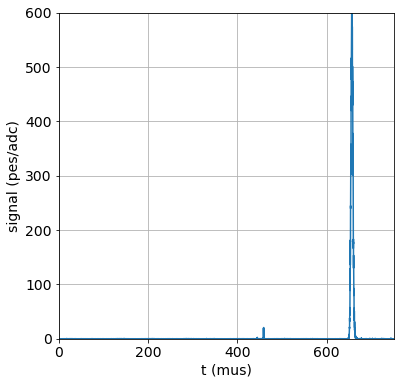

In [206]:
event=13
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  600,
                            figsize=(6,6))

In [207]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 444.175  444.2    444.225  444.25   444.275  444.3    444.325  444.35 ] µs
 Time @ max energy: 444.3
 Width: 0.175 µs
 Height: 2.0336971125172068 pes
 Energy: 7.311180461107634 pes
 Charge: 0.0 pes
 RMS: 0.043557436005058604 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 24
       Times: [ 444.475  444.5    444.525  444.55   444.575  444.6    444.625  444.65
 444.675  444.7    444.725  444.75   444.775  444.8    444.825  444.85
 444.875  444.9    444.925  444.95   444.975  445.     445.025  445.05 ] µs
       Time @ max energy: 444.7
       Width: 0.575 µs
       Height: 2.678008158275016 pes
       Energy: 23.501100720859583 pes
       Charge: 0.0 pes
       RMS: 0.14044480801485204 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 33
       Times: [ 458.375  458.4    458.425 

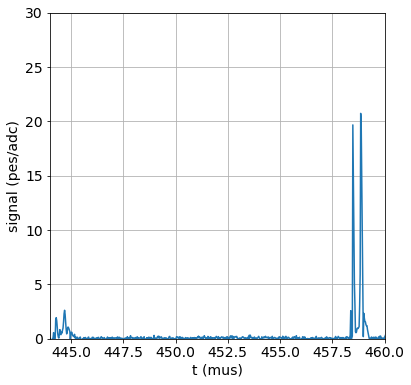

In [208]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =444,
                            t_max      = 460,
                            signal_min =    0,
                            signal_max =  30,
                            figsize=(6,6))

In [209]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 19
       Times: [ 649.41130104  650.42775204  651.39583014  652.37172268  653.3570646
 654.32383794  655.30880832  656.29054815  657.27652329  658.25043614
 659.24291039  660.23408819  661.20149201  662.21416086  663.24188935
 664.20098982  665.21941377  651.82424859  667.24153205] µs
       Time @ max energy: 656.2905481455882
       Width: 2.412947551759542 µs
       Height: 23706.303821823654 pes
       Energy: 132167.84988924378 pes
       Charge: 0.0 pes
       RMS: 2.2040339994409335 µs]

## Event 14

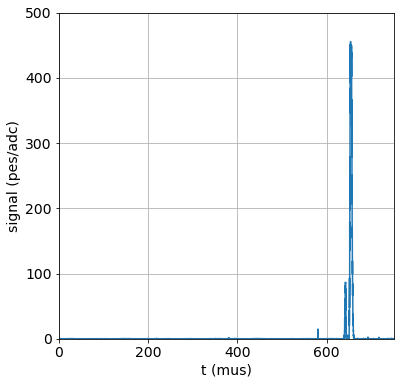

In [211]:
event=14
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  500,
                            figsize=(6,6))

In [212]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 380.475  380.5    380.525  380.55   380.575] µs
 Time @ max energy: 380.525
 Width: 0.1 µs
 Height: 1.498976387488824 pes
 Energy: 5.281278975850675 pes
 Charge: 0.0 pes
 RMS: 0.030688665705661214 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 380.875  380.9    380.925  380.95   380.975] µs
 Time @ max energy: 380.925
 Width: 0.1 µs
 Height: 1.5019994510055903 pes
 Energy: 5.294153646762748 pes
 Charge: 0.0 pes
 RMS: 0.030695999744731143 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 13
       Times: [ 580.425  580.45   580.475  580.5    580.525  580.55   580.575  580.6
 580.625  580.65   580.675  580.7    580.725] µs
       Time @ max energy: 580.5
       Width: 0.3 µs
       Height: 14.972542061509957 pes
       Energy: 66.96619399964284 pes
       Charge: 0.0 pes
       RMS: 0.055320

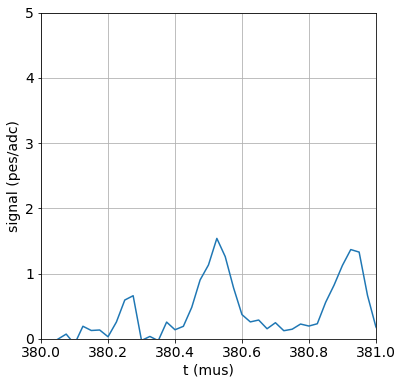

In [214]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =380,
                            t_max      = 381,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

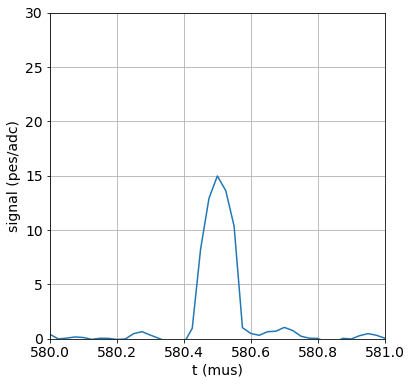

In [215]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =580,
                            t_max      = 581,
                            signal_min =    0,
                            signal_max =  30,
                            figsize=(6,6))

In [216]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 650.27191456  651.20965224  652.16565818  653.10246519  654.08790957
 655.0913205   656.06004186  657.02922152  658.02868039  659.01823167
 659.95302574  660.97891695  661.7640621 ] µs
       Time @ max energy: 655.091320495164
       Width: 11.492147533872746 µs
       Height: 17038.248568974584 pes
       Energy: 89809.96464356412 pes
       Charge: 0.0 pes
       RMS: 1.7760646685625316 µs]

### Conclusions

- S1 "doubling" seems something different. It appears that S1 like signals become very long (shaping effect of FEE?). The doubling is related with the signal rising up, then down, the up again. 
- There is some extra scintillation, but many events are clean. The main issue is to understand how to resolve S1s
- S2 cut at 1 pes kills tails.
- We seem to have very little Krypton and some background
- Lifetime may be good, but needs to be measured.